In [1]:
import skrub
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer

import sempipes

dataset = skrub.datasets.fetch_midwest_survey()

responses = skrub.var("response", dataset.X)
responses = responses.skb.subsample(n=100).skb.set_description(dataset.metadata["description"])

labels = skrub.var("labels", dataset.y)
labels = labels.skb.subsample(n=100).skb.set_name(dataset.metadata["target"])

responses = responses.skb.mark_as_X()
labels = labels.skb.mark_as_y()

responses_with_additional_features = responses.with_sem_features(
    nl_prompt="""
        Compute additional demographics-related features, use your intrinsic knowledge about the US. 
        Take into account how the identification with the country or regions of it changed over the generations.         
        Also think about how the identification differs per class and education. The midwest is generally associated 
        with "Midwestern values" — friendliness, modesty, hard work, and community-mindedness.
    """,
    name="demographic_features",
    how_many=5,
)

feature_encoder = TableVectorizer()
encoded_responses = responses_with_additional_features.skb.apply(feature_encoder)

learner = HistGradientBoostingClassifier()
model = encoded_responses.skb.apply(learner, y=labels)

	> Querying 'openai/gpt-4.1' with 2 messages...'
	> Computed 5 new feature columns: ['Age_Group_Num', 'Education_Level_Num', 'Income_Bracket_Num', 'Is_Midwest_Resident', 'Midwest_Identity_Score'], removed 0 feature columns: []


In [2]:
from sempipes.optimisers.search_strategy import TreeSearch

sempipes.set_config(
    sempipes.Config(
        llm_for_code_generation=sempipes.LLM(
            name="gemini/gemini-2.5-flash",
            parameters={"temperature": 0.3},
        ),
        llm_for_batch_processing=sempipes.LLM(
            name="ollama/gemma3:1b",
            parameters={"api_base": "http://localhost:11434", "temperature": 0.0},
        ),
    )
)

# Note that this should be done on a separate validation set in a real world use case
outcomes = sempipes.optimise_olopro(
    model, "demographic_features", budget=12, scoring="accuracy", cv=5, search=TreeSearch()
)

--- COMPUTING PIPELINE SUMMARY for context-aware optimisation ---
### Processing trial 0
  --- Fitting pipeline
  --- Evaluating pipeline via cross-validation
  --- Score changed to 0.8023339852395555
### Processing trial 1
  --- Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 4 messages...'
	> Computed 5 new feature columns: ['age_numeric', 'education_numeric', 'is_self_identified_midwesterner', 'midwest_state_agreement_score', 'personal_midwest_identity_strength'], removed 0 feature columns: []
  --- Evaluating pipeline via cross-validation
  --- Score changed to 0.8035355852266782
### Processing trial 2
  --- Fitting pipeline
	> Querying 'gemini/gemini-2.5-flash' with 6 messages...'
	> Computed 10 new feature columns: ['age_numeric', 'education_numeric', 'household_income_numeric', 'identity_age_interaction', 'identity_education_interaction', 'is_male', 'is_self_identified_midwesterner', 'midwest_state_agreement_score', 'non_midwest_border_state_agreement_score', 'person

In [3]:
best_outcome = max(outcomes, key=lambda x: x.score)
best_outcome.score

0.9314395859993079

In [4]:
print("\n".join(best_outcome.state["generated_code"]))


import numpy as np
import pandas as pd

# (Feature name: is_self_identified_midwesterner)
# Usefulness: This binary feature indicates whether a respondent explicitly identifies their current living region as "Midwest" (after standardizing various spellings). This directly captures a strong form of self-identification, which is highly relevant for predicting their Census_Region and understanding regional identity.
# Input samples: 'What_would_you_call_the_part_of_the_country_you_live_in_now': ['Southern', 'Midwest', 'Mid-west']
df['is_self_identified_midwesterner'] = df['What_would_you_call_the_part_of_the_country_you_live_in_now'].str.lower().str.contains('midwest|mid-west').astype(int)

# (Feature name: midwest_state_agreement_score)
# Usefulness: This feature quantifies how many of the generally accepted core Midwestern states a respondent considers part of the Midwest. It provides a numerical measure of their understanding and definition of the region, which can be a strong indicat

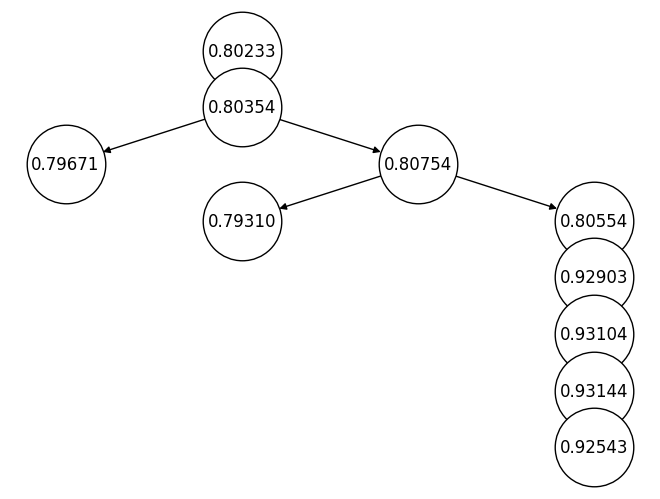

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

attributes = {}
edges = []

for outcome in outcomes:
    node_id = id(outcome.search_node)
    if outcome.search_node.parent is not None:
        parent_node_id = id(outcome.search_node.parent)
        edges.append((parent_node_id, node_id))
    attributes[node_id] = {"score": f"{outcome.score:.5f}"}

G = nx.DiGraph()
G.add_edges_from(edges)
nx.set_node_attributes(G, attributes)

labels = nx.get_node_attributes(G, "score")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

nx.draw(
    G,
    pos,
    with_labels=True,
    labels=labels,
    arrows=True,
    node_size=3200,
    node_color="white",
    edgecolors="black",
)
plt.show()